In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import proplot as pplt
import seaborn as sns
import pandas as pd
import torch
import gymnasium as gym
import gym_bart
import itertools
from umap import UMAP
from plotting_utils import (
    set_rc, 
    add_abc_to_subaxes, 
    colors, 
    rgb_colors
)
from model_evaluation import (
    forced_action_evaluate, 
    meta_bart_callback,
    meta_bart_multi_callback,
    reshape_parallel_evalu_res,
    forced_action_evaluate_multi,
)
from bart_behavior_analysis import (
    plot_1color5fsize,
    plot_1colornfsize
)
from read_experiments import average_runs, load_exp_df
import re

from functools import partial
import sys
sys.path.append('../')
from ppo.envs import make_vec_env
import pickle
from tqdm import tqdm
from collections import defaultdict

from bart_representation_analysis import *
from bart_compress_visualize_decode import *
from sklearn.decomposition import PCA

set_rc()

In [ ]:
def get_impulsivity_data(res, impulsive_thres=0.2, ep=None, layer='shared1',
                         load_global=True):
    if ep is not None:
        if type(ep) != list:
            ep = [ep]
        v = np.vstack([res['values'][e] for e in ep])
        ap = np.vstack([res['action_probs'][e] for e in ep])[:, 1]
        activ = np.vstack([res['activations'][layer][e] for e in ep])
    else:
        v = np.vstack(res['values'])
        ap = np.vstack(res['action_probs'])[:, 1]
        activ = np.vstack(res['activations'][layer])
        
    imp_steps = ap < impulsive_thres
    
    if load_global:
        globals()['v'] = v
        globals()['ap'] = ap
        globals()['activ'] = activ
        globals()['imp_steps'] = imp_steps

    return {
        'v': v,
        'ap': ap,
        'activ': activ,
        'imp_steps': imp_steps
    }

In [385]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

def get_cluster_activations(activ, kmeans=None, k=5):
    '''
    Use kmeans on hidden state data to cluster the data after scaling
    km: if passed, use an already fit KMeans model, rather than fitting a new one
    '''
    data = activ.T  # change to [64, T]
    scaler = TimeSeriesScalerMeanVariance()
    data_normalized = scaler.fit_transform(data[:, :, np.newaxis])  # Shape becomes [64, T, 1]
    data_normalized = data_normalized.squeeze()  # Back to shape [64, T]
    if kmeans is None:
        kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(data_normalized)
    
    cluster_data = [data_normalized[labels == i] for i in range(kmeans.n_clusters)]
    cluster_activations = np.vstack([c.mean(axis=0) for c in cluster_data]).T
    return cluster_activations, labels, kmeans


def find_k_cluster_activations(res):
    imp = get_impulsivity_data(res, load_global=False)
    activ = imp['activ']
    ap = imp['ap'].reshape(-1, 1)
    
    data = activ.T  # change to [64, T]
    scaler = TimeSeriesScalerMeanVariance()
    data_normalized = scaler.fit_transform(data[:, :, np.newaxis])  # Shape becomes [64, T, 1]
    data_normalized = data_normalized.squeeze()  # Back to shape [64, T]

    max_k = 10  # Maximum number of clusters to try
    silhouette_scores = []
    r2_scores = []
    ks = range(2, max_k + 1)

    lr = LinearRegression()
    lr.fit(activ, ap)
    ypred = lr.predict(activ)
    best_r2 = r2_score(ap, ypred)
    
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(data_normalized)
        silhouette_avg = silhouette_score(data_normalized, labels)
        silhouette_scores.append(silhouette_avg)

        # Test how good the cluster compression explains behavior
        cluster_activations, _, _ = get_cluster_activations(activ, kmeans)
        lr = LinearRegression()
        lr.fit(cluster_activations, ap)
        ypred = lr.predict(cluster_activations)
        r2_scores.append(r2_score(ap, ypred))
        
    r2_scores = np.array(r2_scores)
    silhouette_scores = np.array(silhouette_scores)
    
    # Ensure that enough info is kept in clusters to keep r2 prediction high
    min_r2_idx = np.argmax(r2_scores > 0.8*best_r2)
    best_k = np.argmax(silhouette_scores[min_r2_idx:]) + min_r2_idx + 2
    
    return best_k


def train_lasso_with_value_for_impulsivity(res, activ=None, alpha=1e-3, impulsive_thres=0.2):
    '''
    Train a Lasso regression to determine the importance of certain features
    on impulsivity measurements
    impulsive_thres: threshold below which we consider steps impulsive
    activ: optionally pass specific activations, such as cluster activations
    '''
    imp = get_impulsivity_data(res, impulsive_thres=impulsive_thres, load_global=False)
    v = imp['v']
    ap = imp['ap']
    imp_steps = imp['imp_steps']
    if activ is None:
        activ = imp['activ']
    value_estimation = v[imp_steps].reshape(-1)
    impulsivity = ap[imp_steps].reshape(-1)
    activ = activ[imp_steps]
    
    X = np.column_stack((value_estimation, activ))
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_scaled, impulsivity)

    # 4. Identifying Significant Neurons
    # Extract coefficients and feature names
    coefficients = lasso.coef_
    intercept = lasso.intercept_

    # Create a DataFrame for easy interpretation
    feature_names = ['value_estimation'] + [f'activ_{i}' for i in range(activ.shape[1])]
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    # Filter out features with non-zero coefficients
    significant_features = coef_df[coef_df['Coefficient'] != 0]
    return significant_features


def split_by_ep(res, data):
    '''After combining steps, return back to episode based split'''
    ep_lens = [len(o) for o in res['obs']]

    ep_data = []
    cur_step = 0
    for ep_len in ep_lens:
        ep_data.append(data[cur_step:cur_step+ep_len])
        cur_step += ep_len
    return ep_data
    

def visualize_cluster_activations(res, klabels, ep=8, layer='shared1'):
    '''
    Visualize the compositionn of each cluster across a single episode
    '''
    k = np.max(klabels) + 1
    if k > 20:
        print('k > 20, not creating plot')
        return None

    activ = res['activations'][layer][ep]
    cluster_data = [activ[:, klabels == i] for i in range(k)]
    fig, axs = pplt.subplots(nrows=k, sharex=True, sharey=True, 
                             figwidth=5, refaspect=4)
        
    for i, ax in enumerate(axs):
        ax.format(title=f'Cluster {i}')
        
        for j in range(cluster_data[i].shape[1]):
            ax.plot(cluster_data[i][:, j], alpha=0.5)
        ax.plot(cluster_data[i].mean(axis=1), c='black')
    fig.format(suptitle='Time Series Clusters Visualization', xlabel='Time', ylabel='Normalized Value')


def get_size_episode_coverage(res):
    '''
    Get episodes out of the 17 episodes that capture the different sizes the agent
    achieved, to use for visualization rather than using all episodes
    '''
    ep_idxs = []
    kept_means = []
    means = np.array([np.mean(s[-10:]) for s in res['data']['last_size']])
    for ep in range(17):
        if np.all(np.abs(np.array(kept_means) - means[ep]) > 0.02):
            kept_means.append(means[ep])
            ep_idxs.append(ep)
    return ep_idxs
    

def visualize_smoothed_cluster_episodes(res, klabels, layer='shared1',
                                        color_by_mu=False, minimal_size_coverage=False):
    '''
    Visualize how clustered acivations work smoothed across episodes and colored
    by balloon size
    color_by_mu: if True, color lines based on true balloon size, otherwise
        color by the average size the agent achieved on the episode
    minimal_size_coverage: if True, only use as many episodes as needed to see range of 
        sizes achieved
    '''
    k = np.max(klabels) + 1
    if k > 20:
        print('k > 20, not creating plot')
        return None
    fig, ax = pplt.subplots(nrows=k, sharex=True, sharey=False, 
                             figwidth=5, refaspect=4)
    
    if minimal_size_coverage:
        ep_idxs = get_size_episode_coverage(res)
    else:
        ep_idxs = range(17)

    if color_by_mu:
        bsizes = np.arange(0.2, 1.01, 0.05)
        vmin = 0.2
        vmax = 1
    else:
        bsizes = []
        for ep in ep_idxs:
            popped = np.array(res['data']['popped'][ep])
            sizes = np.array(res['data']['last_size'][ep])
            bsizes.append(np.mean(sizes[~popped]))
        vmin = np.min(bsizes)
        vmax = np.max(bsizes) + 0.05
        
    for i in range(k):
        for j, ep in enumerate(ep_idxs):
            s = bsizes[j]
            c = get_color_from_colormap(s, vmin, vmax, to_hex=False) 
            cluster_activ = res['activations'][layer][ep][:, klabels == i].mean(axis=1)
            ax[i].plot(list(pd.Series(cluster_activ).ewm(alpha=0.01).mean()),
                    c=c)

    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    cbar = fig.colorbar(sm)
    cbar.set_label(label='$\mu$', rotation=0, labelpad=10)
    ax[0].format(title='RNN Clusters')
    ax.format(xlabel='time step')
    for i in range(k):
        ax[i].format(ylabel=f'Cluster {i+1}')
 
 
def visualize_smoothed_pca_episodes(res, n_components=3, layer='shared1',
                                        color_by_mu=False, minimal_size_coverage=False):
    '''
    Visualize how clustered acivations work smoothed across episodes and colored
    by balloon size
    color_by_mu: if True, color lines based on true balloon size, otherwise
        color by the average size the agent achieved on the episode
    minimal_size_coverage: if True, only use as many episodes as needed to see range of 
        sizes achieved
    '''
    fig, ax = pplt.subplots(nrows=n_components, sharex=True, sharey=False, 
                             figwidth=5, refaspect=4)
    
    if minimal_size_coverage:
        ep_idxs = get_size_episode_coverage(res)
    else:
        ep_idxs = range(17)

    if color_by_mu:
        bsizes = np.arange(0.2, 1.01, 0.05)
        vmin = 0.2
        vmax = 1
    else:
        bsizes = []
        for ep in ep_idxs:
            popped = np.array(res['data']['popped'][ep])
            sizes = np.array(res['data']['last_size'][ep])
            bsizes.append(np.mean(sizes[~popped]))
        vmin = np.min(bsizes)
        vmax = np.max(bsizes) + 0.05
        
    pcas = comb_pca(res, layer)
    for i in range(n_components):
        for j, ep in enumerate(ep_idxs):
            s = bsizes[j]
            c = get_color_from_colormap(s, vmin, vmax, to_hex=False) 
            pca = pcas[ep][:, i]
            ax[i].plot(list(pd.Series(pca).ewm(alpha=0.01).mean()),
                    c=c)

    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    cbar = fig.colorbar(sm)
    cbar.set_label(label='$\mu$', rotation=0, labelpad=10)
    ax[0].format(title='RNN PCAs')
    ax.format(xlabel='time step')
    for i in range(n_components):
        ax[i].format(ylabel=f'PCA {i+1}')
        
            
def visualize_episode_values(res, color_by_mu=False, minimal_size_coverage=False):
    if minimal_size_coverage:
        ep_idxs = get_size_episode_coverage(res)
    else:
        ep_idxs = range(17)

    if color_by_mu:
        bsizes = np.arange(0.2, 1.01, 0.05)
        vmin = 0.2
        vmax = 1
    else:
        bsizes = []
        for ep in ep_idxs:
            popped = np.array(res['data']['popped'][ep])
            sizes = np.array(res['data']['last_size'][ep])
            bsizes.append(np.mean(sizes[~popped]))
        vmin = np.min(bsizes)
        vmax = np.max(bsizes) + 0.05
        
    fig, ax = pplt.subplots()
    for j, ep in enumerate(ep_idxs):
        s = bsizes[j]
        c = get_color_from_colormap(s, vmin, vmax, to_hex=False)
        ax.plot(list(pd.Series(res['values'][ep].reshape(-1)).ewm(alpha=0.1).mean()), 
                c=c, alpha=0.5)
    print(bsizes)
    ax.format(xlabel='time step', ylabel='Value prediction')
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    cbar = fig.colorbar(sm)
    cbar.set_label(label='$\mu$', rotation=0, labelpad=10)

In [2]:
size = np.arange(0.2, 1.01, 0.05)
env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 2500, 'num_balloons': 50,
                            'inflate_noise': 0,
                            'fix_sizes': [0, s, 0]} for s in size]

evalu = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=env_kwargs, 
                num_processes=17,
                seed=1,
                deterministic=False,
                with_activations=True)

In [3]:

model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/p1.5n50_2/150.pt') #Agent A
# model, (obs_rms, ret_rms) = \
#     torch.load(f'../saved_checkpoints/meta_v2/p1.5n50_1/150.pt') #Agent B
# model, (obs_rms, ret_rms) = \
#     torch.load(f'../saved_checkpoints/meta_v2/p2.0n50pop0.1_2/240.pt') #Agent C
# model, (obs_rms, ret_rms) = \
#     torch.load(f'../saved_checkpoints/meta_v2/p1.5n50pop0.1_2/50.pt') #Agent C
# model, (obs_rms, ret_rms) = \
#     torch.load(f'../saved_checkpoints/meta_v2/p1.7n50pop0.1_1/100.pt') #Agent C
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=50)
# plot_1colornfsize(res)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.balloon_mean_sizes to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.balloon_mean_sizes` for environment variables or `env.get_wrapper_attr('balloon_mean_sizes')` that will search the reminding wrappers.
  logger.warn(


[0.16428571428571434, 0.2078125, 0.2055555555555556, 0.2961538461538461, 0.3578947368421052, 0.3855263157894737, 0.4605263157894736, 0.49390243902439024, 0.5011363636363636, 0.501, 0.502, 0.5010204081632652, 0.512, 0.498, 0.5139999999999999, 0.5139999999999999, 0.507]


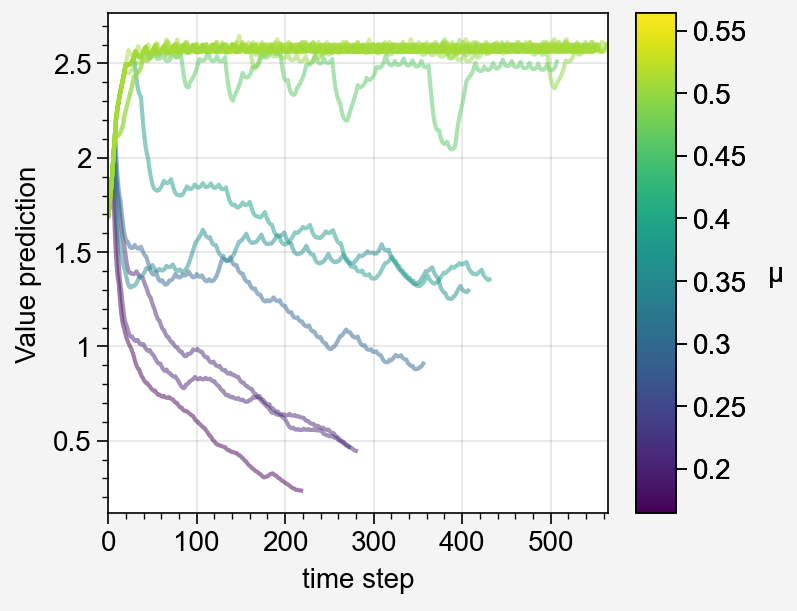

In [4]:
visualize_episode_values(res)

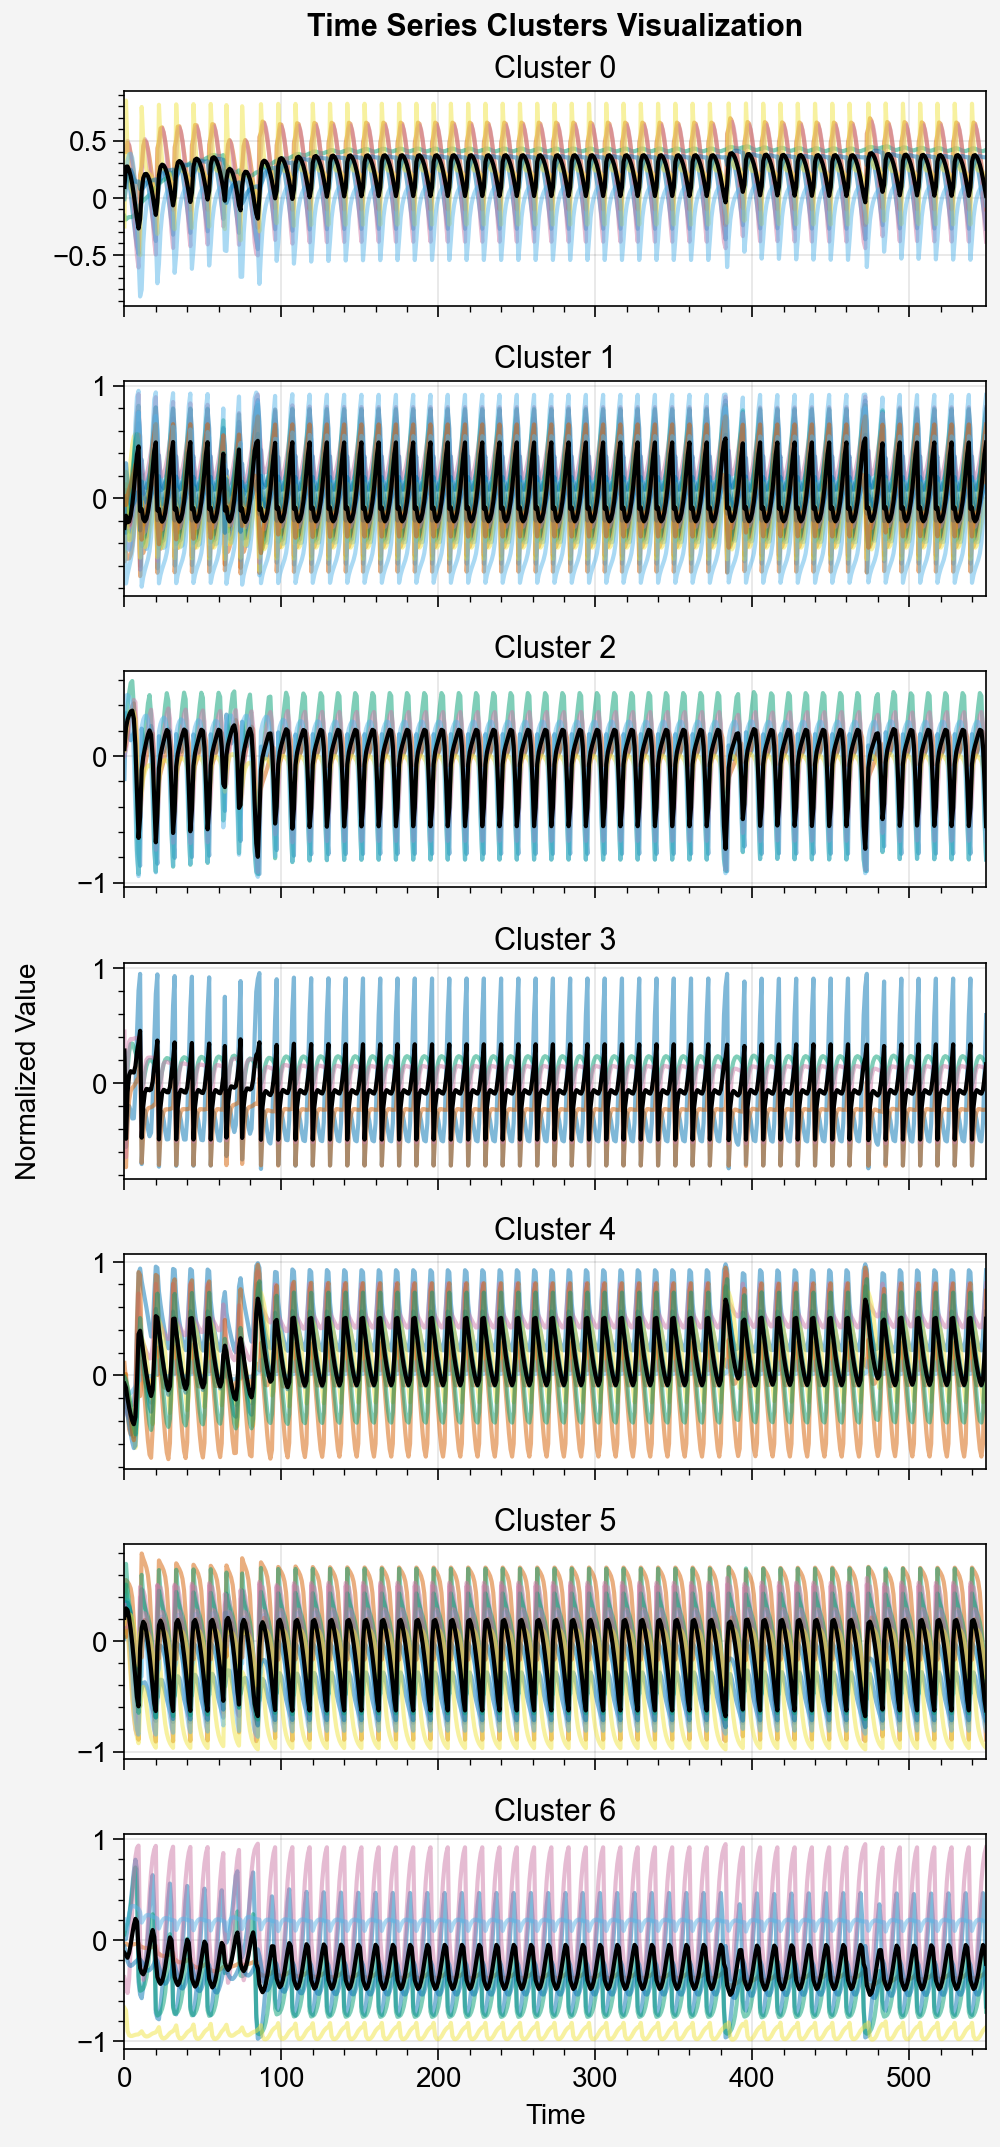

In [5]:
k = find_k_cluster_activations(res)
imp = get_impulsivity_data(res)
activ = imp['activ']
cluster_activ, labels, kmeans = get_cluster_activations(activ, k=k)
feature_importances = train_lasso_with_value_for_impulsivity(res, cluster_activ)
ep_cact = split_by_ep(res, cluster_activ)
visualize_cluster_activations(res, labels)

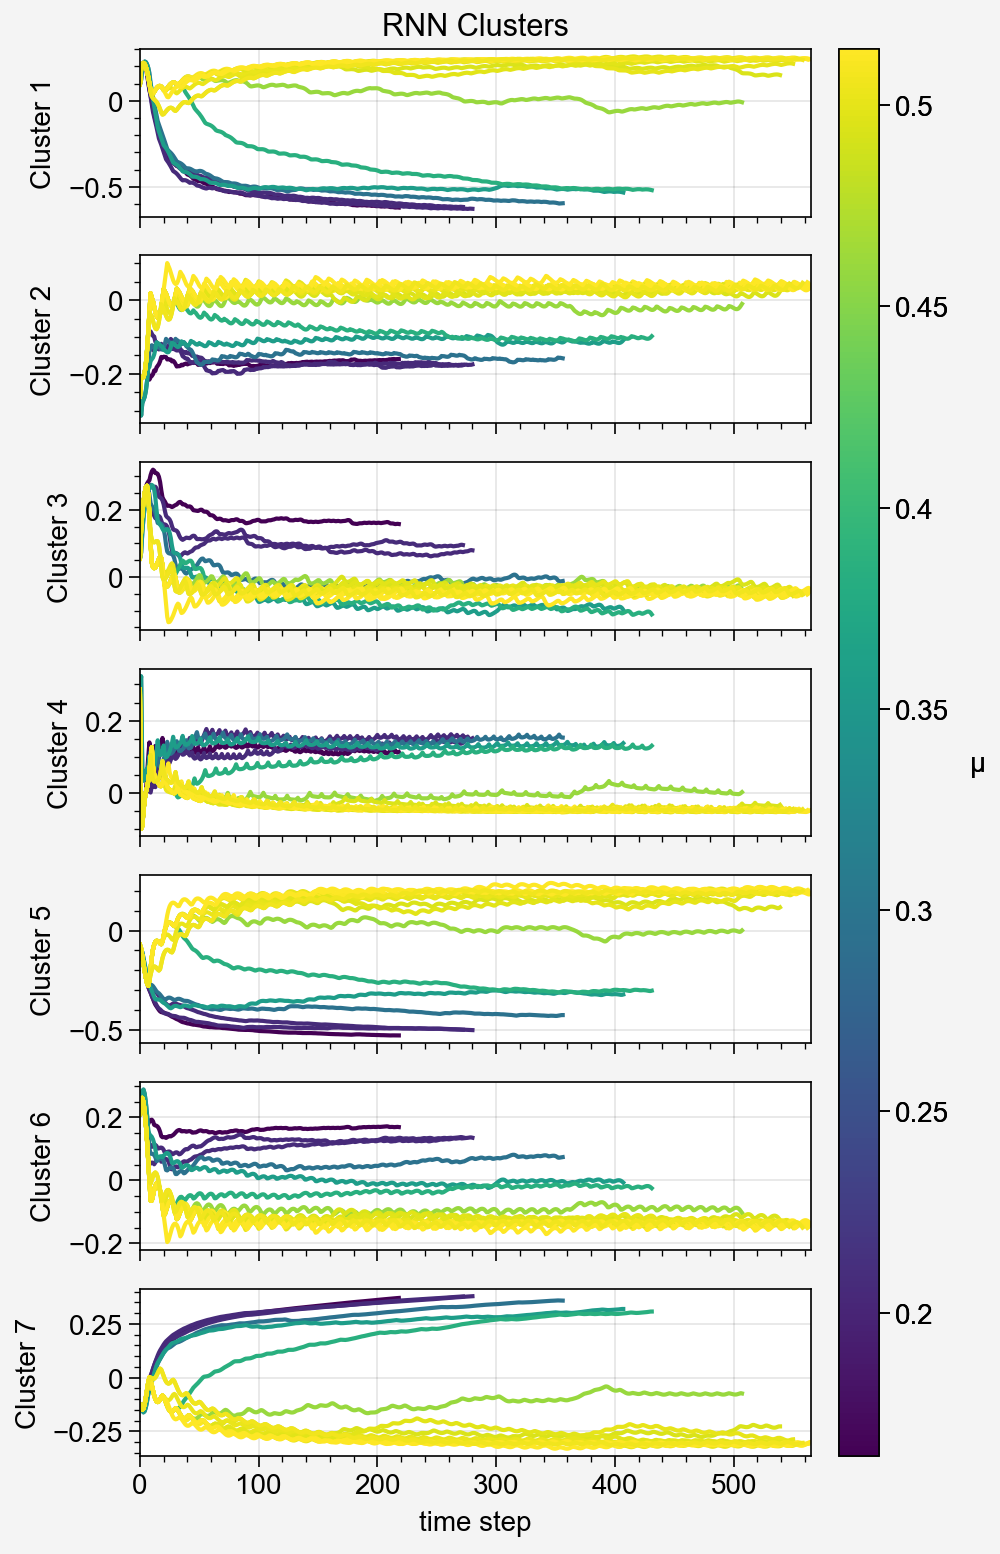

In [ ]:
visualize_smoothed_cluster_episodes(res, labels)

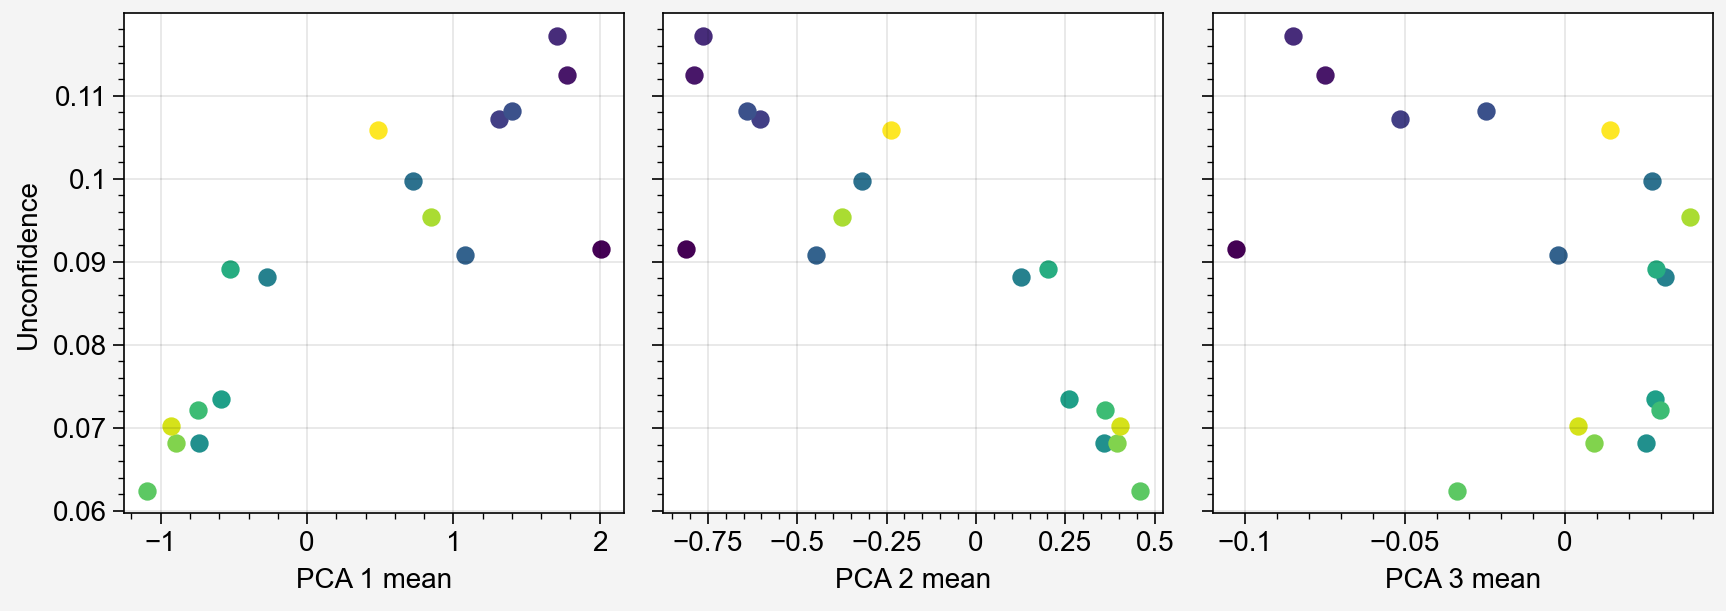

In [600]:
pcas = comb_pca(res)
unc = []
pca_scores = []
for ep in range(17):
    unc.append(score_unconfidence(res, ep))
for i in range(3):
    pca_score = []
    for ep in range(17):
        pca_score.append(pcas[ep][:, i].mean())
    pca_scores.append(pca_score)

fig, ax = pplt.subplots(ncols=3, sharex=False)
for i in range(3):
    for ep in range(17):
        s = balloon_sizes[ep]
        c = get_color_from_colormap(s, 0.2, 1, to_hex=False)
        ax[i].scatter(pca_scores[i][ep], unc[ep], c=c)
        
    ax[i].format(xlabel=f'PCA {i+1} mean')
ax.format(ylabel='Unconfidence')

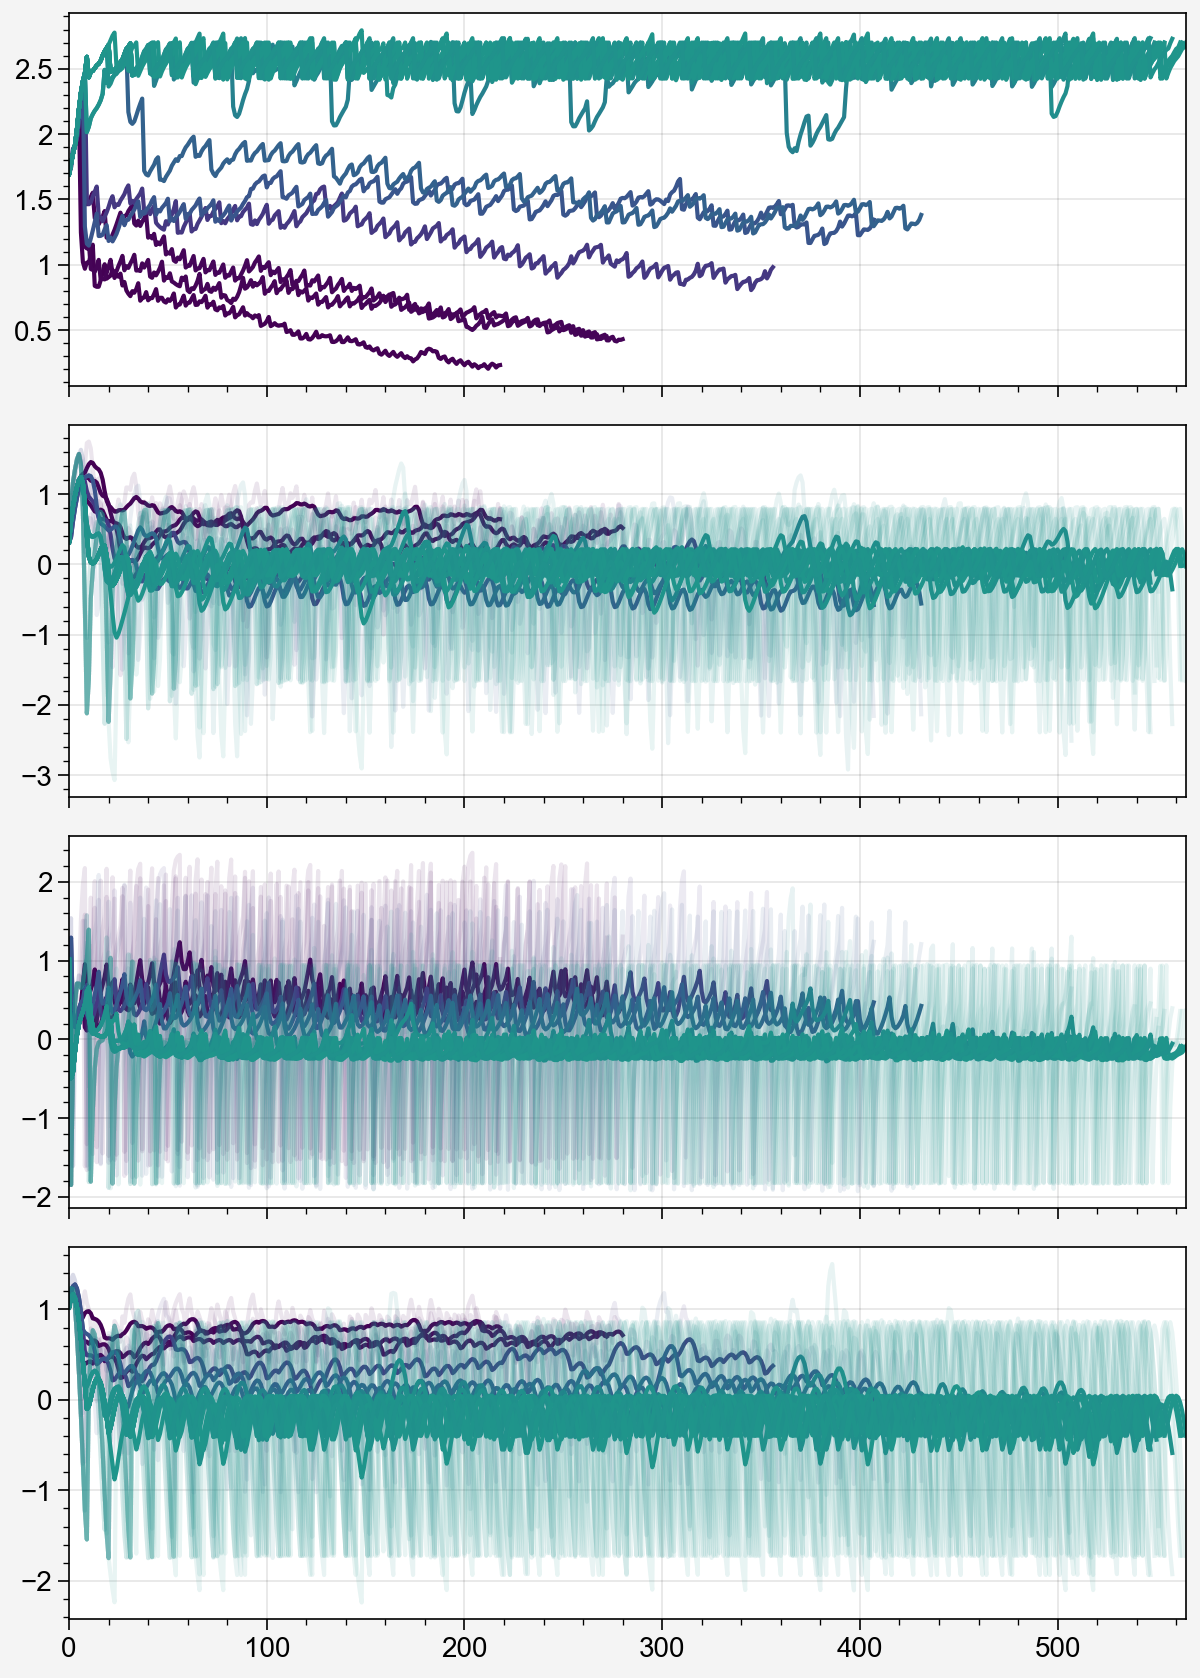

In [304]:
fig, ax = pplt.subplots(nrows=4, refaspect=3, figwidth=6)

plot_clusters = [2, 3, 5]

for ep in range(17):
    popped = np.array(res['data']['popped'][ep])
    sizes = np.array(res['data']['last_size'][ep])
    s = np.mean(sizes[~popped])
    c = get_color_from_colormap(s, 0.2, 0.8, to_hex=False)
    ax[0].plot(res['values'][ep], c=c)
    for i in range(3):
        clus = plot_clusters[i]
        ax[i+1].plot(ep_cact[ep][:, clus], c=c, alpha=0.1)
        smoothed = list(pd.Series(list(ep_cact[ep][:, clus])).ewm(alpha=0.1).mean())
        ax[i+1].plot(smoothed, c=c)

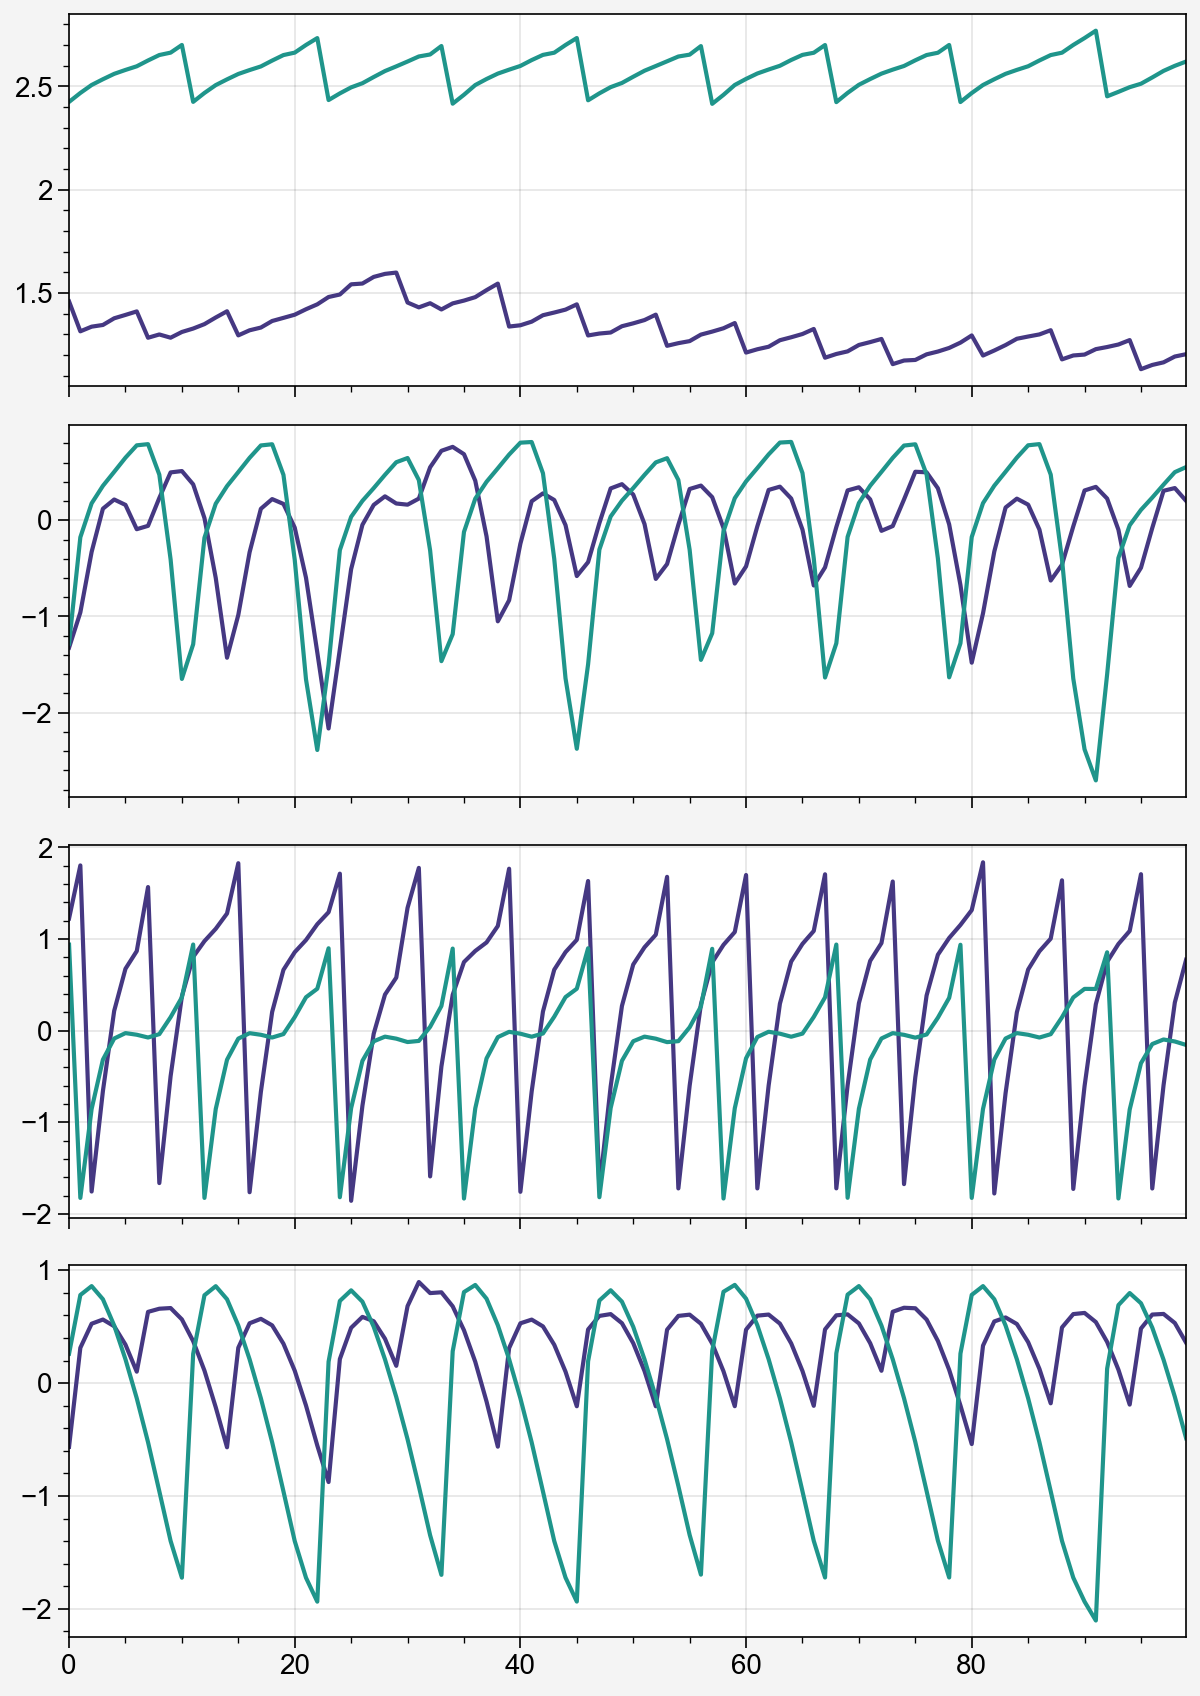

In [310]:
fig, ax = pplt.subplots(nrows=4, refaspect=3, figwidth=6)

plot_clusters = [2, 3, 5]


for ep in [3, 15]:
    popped = np.array(res['data']['popped'][ep])
    sizes = np.array(res['data']['last_size'][ep])
    s = np.mean(sizes[~popped])
    c = get_color_from_colormap(s, 0.2, 0.8, to_hex=False)
    ax[0].plot(res['values'][ep][100:200], c=c)
    for i in range(3):
        clus = plot_clusters[i]
        ax[i+1].plot(ep_cact[ep][100:200, clus], c=c, alpha=1)
        # smoothed = list(pd.Series(list(ep_cact[ep][100:200, clus])).ewm(alpha=0.1).mean())
        # ax[i+1].plot(smoothed, c=c)

In [120]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

imp = get_impulsivity_data(res)
value_estimation = v[imp_steps].reshape(-1)
hidden_states = activ[imp_steps]
impulsivity = ap[imp_steps].reshape(-1)
# Combine value_estimation and hidden_states into a feature matrix
X = np.column_stack((value_estimation, hidden_states))
# 1. Transpose Hidden States
# Shape: (n_neurons, n_samples)
hidden_states_T = hidden_states.T

# 2. Feature Scaling for Clustering
# Standardize neuron activation patterns
scaler = StandardScaler()
hidden_states_scaled = scaler.fit_transform(hidden_states_T)

# 3. Clustering Neurons
# Choose the number of clusters (k)
k = 4  # Adjust based on data analysis
kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(hidden_states_scaled)

# 4. Aggregating Cluster Activations
# Initialize cluster activations matrix
cluster_activations = np.zeros((hidden_states.shape[0], k))

for cluster_idx in range(k):
    # Indices of neurons in the current cluster
    neuron_indices = np.where(clusters == cluster_idx)[0]
    # Mean activation of the cluster at each time step
    cluster_activations[:, cluster_idx] = hidden_states[:, neuron_indices].mean(axis=1)

# Cluster feature names
cluster_feature_names = [f'cluster_{i}' for i in range(k)]

# 5. Regression Analysis Including Clusters
# Combine value_estimation and cluster_activations
X = np.column_stack((value_estimation, cluster_activations))
feature_names = ['value_estimation'] + cluster_feature_names

# Add a constant term for intercept
X_with_const = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(impulsivity, X_with_const)
results = model.fit()

# 6. Identifying Significant Clusters
# Create a summary table
summary_table = pd.DataFrame({
    'Feature': ['Intercept'] + feature_names,
    'Coefficient': results.params,
    'P-value': results.pvalues
})

print("Regression Results:")
print(summary_table)

# Identify significant clusters (e.g., p-value < 0.05)
significant_clusters = summary_table[(summary_table['P-value'] < 0.05) & (summary_table['Feature'].str.contains('cluster'))]

print("\nSignificant Clusters:")
print(significant_clusters)

Regression Results:
            Feature  Coefficient        P-value
0         Intercept     0.117333  1.342427e-267
1  value_estimation    -0.041096  2.073085e-139
2         cluster_0     0.020060   1.698687e-14
3         cluster_1    -0.256340  9.135213e-144
4         cluster_2    -0.182171  4.769964e-186
5         cluster_3     0.008576   2.171073e-02

Significant Clusters:
     Feature  Coefficient        P-value
2  cluster_0     0.020060   1.698687e-14
3  cluster_1    -0.256340  9.135213e-144
4  cluster_2    -0.182171  4.769964e-186
5  cluster_3     0.008576   2.171073e-02


In [133]:
X = cluster_activations
y = value_estimation.reshape(-1, 1)
X_with_const = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X_with_const)
results = model.fit()

feature_names = cluster_feature_names
# 6. Identifying Significant Clusters
# Create a summary table
summary_table = pd.DataFrame({
    'Feature': ['Intercept'] + feature_names,
    'Coefficient': results.params,
    'P-value': results.pvalues
})

print("Regression Results:")
print(summary_table)
significant_clusters = summary_table[(summary_table['P-value'] < 0.05) & (summary_table['Feature'].str.contains('cluster'))]

print("\nSignificant Clusters:")
print(significant_clusters)


Regression Results:
     Feature  Coefficient        P-value
0  Intercept     1.880510   0.000000e+00
1  cluster_0     1.309221   0.000000e+00
2  cluster_1    -1.804382  1.902666e-123
3  cluster_2    -1.820053   0.000000e+00
4  cluster_3    -1.017727  2.445957e-282

Significant Clusters:
     Feature  Coefficient        P-value
1  cluster_0     1.309221   0.000000e+00
2  cluster_1    -1.804382  1.902666e-123
3  cluster_2    -1.820053   0.000000e+00
4  cluster_3    -1.017727  2.445957e-282


In [184]:
lm = Lasso(alpha=1e-3)

# X = np.column_stack((value_estimation, cluster_activations))
X = np.column_stack((value_estimation, hidden_states))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = impulsivity.reshape(-1, 1)

lm.fit(X_scaled, y)
print(lm.intercept_)
print(lm.coef_)

[0.00737657]
[-0.          0.         -0.00560222  0.         -0.00502008 -0.
  0.         -0.00497191  0.          0.         -0.         -0.
 -0.         -0.          0.          0.          0.00209773  0.
  0.         -0.         -0.         -0.         -0.         -0.
  0.          0.         -0.00325301 -0.         -0.         -0.
  0.          0.          0.          0.         -0.          0.
 -0.          0.00573047 -0.          0.00205557 -0.          0.
 -0.          0.         -0.          0.         -0.          0.
  0.          0.         -0.         -0.          0.          0.
  0.         -0.00938826 -0.00065129 -0.         -0.         -0.
 -0.          0.          0.         -0.          0.        ]


In [116]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# 1. Data Preparation
# Assuming you have the data as specified:
# impulsivity, value_estimation, hidden_states


imp = get_impulsivity_data(res)
value_estimation = v[imp_steps].reshape(-1)
hidden_states = activ[imp_steps]
impulsivity = ap[imp_steps].reshape(-1)
# Combine value_estimation and hidden_states into a feature matrix
X = np.column_stack((value_estimation, hidden_states))

# Feature names for reference
feature_names = ['value_estimation'] + [f'neuron_{i}' for i in range(hidden_states.shape[1])]

# 2. Feature Scaling
# Standardize features to have mean=0 and variance=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Model Fitting with LASSO Regularization
# Use LassoCV to select the best alpha (regularization strength) via cross-validation
lasso = LassoCV(cv=5, random_state=0, max_iter=10000, tol=0.1)
lasso.fit(X_scaled, impulsivity)

# 4. Identifying Significant Neurons
# Extract coefficients and feature names
coefficients = lasso.coef_
intercept = lasso.intercept_

# Create a DataFrame for easy interpretation
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Filter out features with non-zero coefficients
significant_features = coef_df[coef_df['Coefficient'] != 0]
print('R2', r2_score(impulsivity, lasso.predict(X_scaled)))
print('Alpha', lasso.alpha_)

R2 0.7060261157146773
Alpha 4.089228743100292e-05


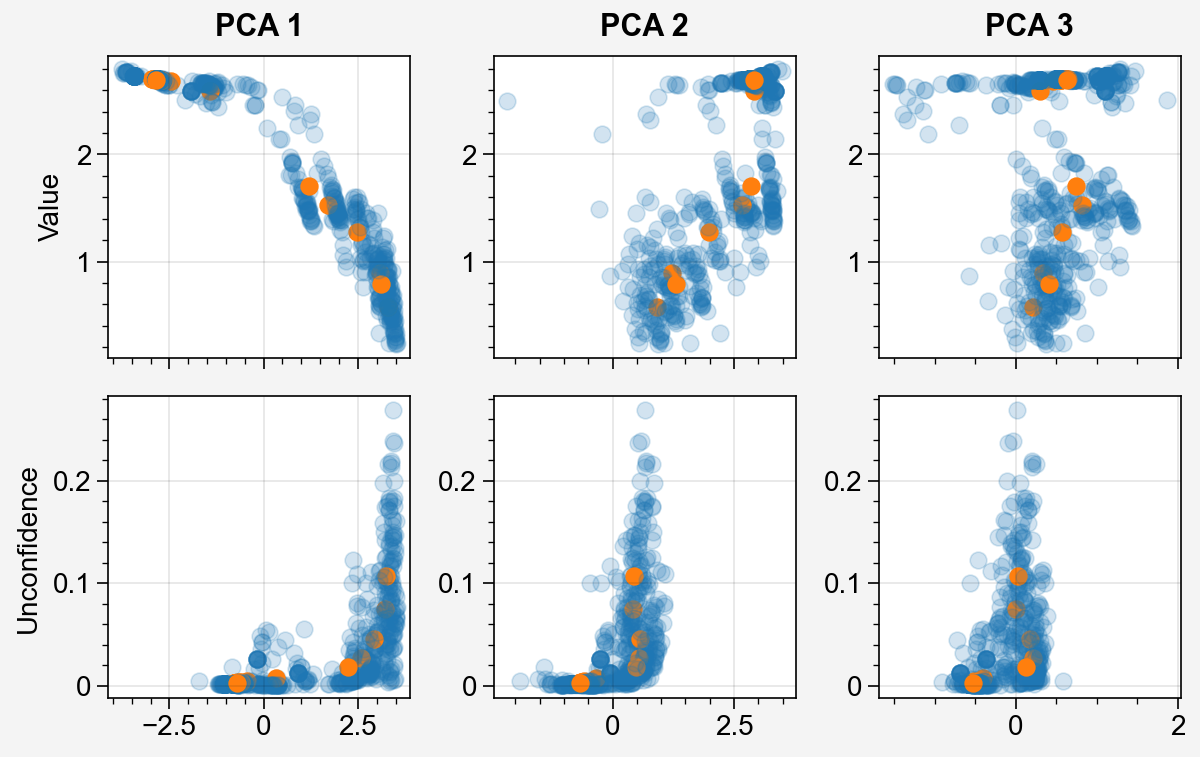

In [944]:
fig, ax = pplt.subplots(ncols=3, nrows=2, figwidth=6, sharey=False)
pcas = comb_pca(res)

for i in range(3):
    for ep in range(17):
        bsteps = np.array(res['data']['balloon_step'][ep])
        v = res['values'][ep].reshape(-1)[bsteps]
        a = pcas[ep][bsteps, i]
        ap = res['action_probs'][ep][:, 1]
        f = 0
        unc_groups = []
        a_groups = []
        for j in range(len(bsteps)):
            rng = np.arange(f, bsteps[j])
            idxs = rng[ap[rng] < 0.5]
            unc_groups.append(ap[idxs].mean())
            a_groups.append(pcas[ep][idxs, i].mean())
            f = bsteps[j]
        ax[0, i].scatter(a, v, alpha=0.2, c=rgb_colors[0])
        ax[0, i].scatter(a.mean(), v.mean(), c=rgb_colors[1])
        ax[1, i].scatter(a_groups, unc_groups,  alpha=0.2, c=rgb_colors[0])
        ax[1, i].scatter(np.mean(a_groups), np.mean(unc_groups), c=rgb_colors[1])
        
ax.format(toplabels=[f'PCA {i+1}' for i in range(3)])
ax[0, 0].format(ylabel='Value')
ax[1, 0].format(ylabel='Unconfidence')

In [23]:
%run bart_compress_visualize_decode

0.7951423765358725


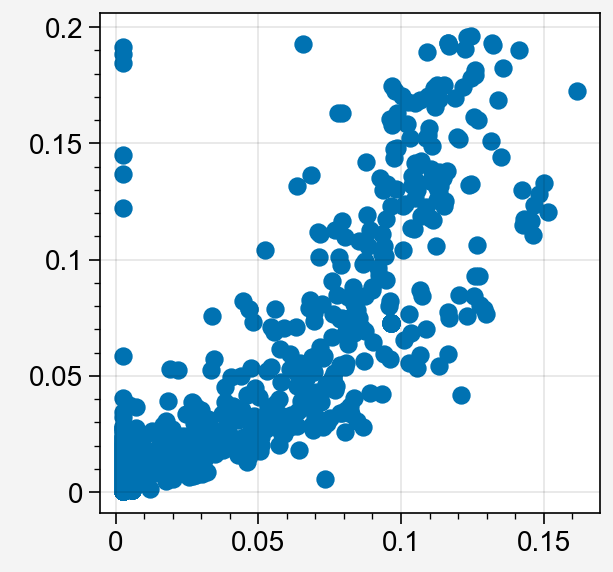

In [15]:
model.eval()
with torch.no_grad():
    ypred, _ = nn_model(x)
    # ypred = model(x)
fig, ax = pplt.subplots()
ax.scatter(ypred, y)
print(r2_score(y, ypred))

In [51]:

ap = np.vstack(res['action_probs'])[:, 1]
ap = ap[ap < 0.5]

steps = np.arange(len(ap))
steps = steps[ap < 0.4]
step_idxs = np.random.choice(steps, 100)
o = torch.tensor(np.vstack(res['obs'])[step_idxs], requires_grad=True)
rnn_hxs = torch.tensor(np.vstack(res['rnn_hxs'])[step_idxs], requires_grad=True)
masks = torch.tensor(res['masks'][0][0])

outputs = model.act(o, rnn_hxs, masks)

target = outputs['probs'][:, 1]
model.zero_grad()
target.mean().backward()

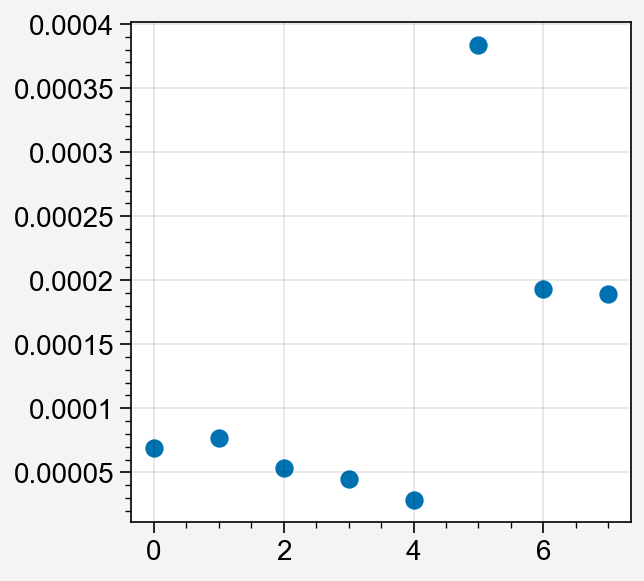

In [59]:
fig, ax = pplt.subplots()
ax.scatter(o.grad.data.abs().squeeze().numpy().mean(axis=0))

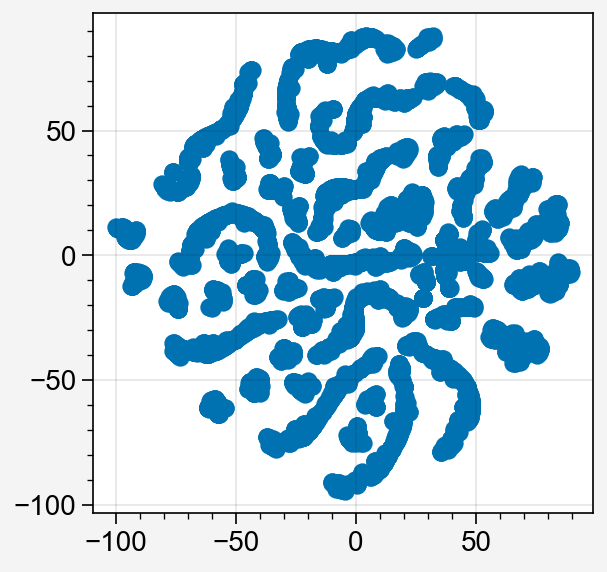

In [61]:
from sklearn.manifold import TSNE

rnn_hxs = np.vstack(res['rnn_hxs'])
tsne = TSNE(n_components=2, random_state=42)
rnn_hxs_2d = tsne.fit_transform(rnn_hxs)

fig, ax = pplt.subplots()
ax.scatter(rnn_hxs_2d[:, 0], rnn_hxs_2d[:, 1])

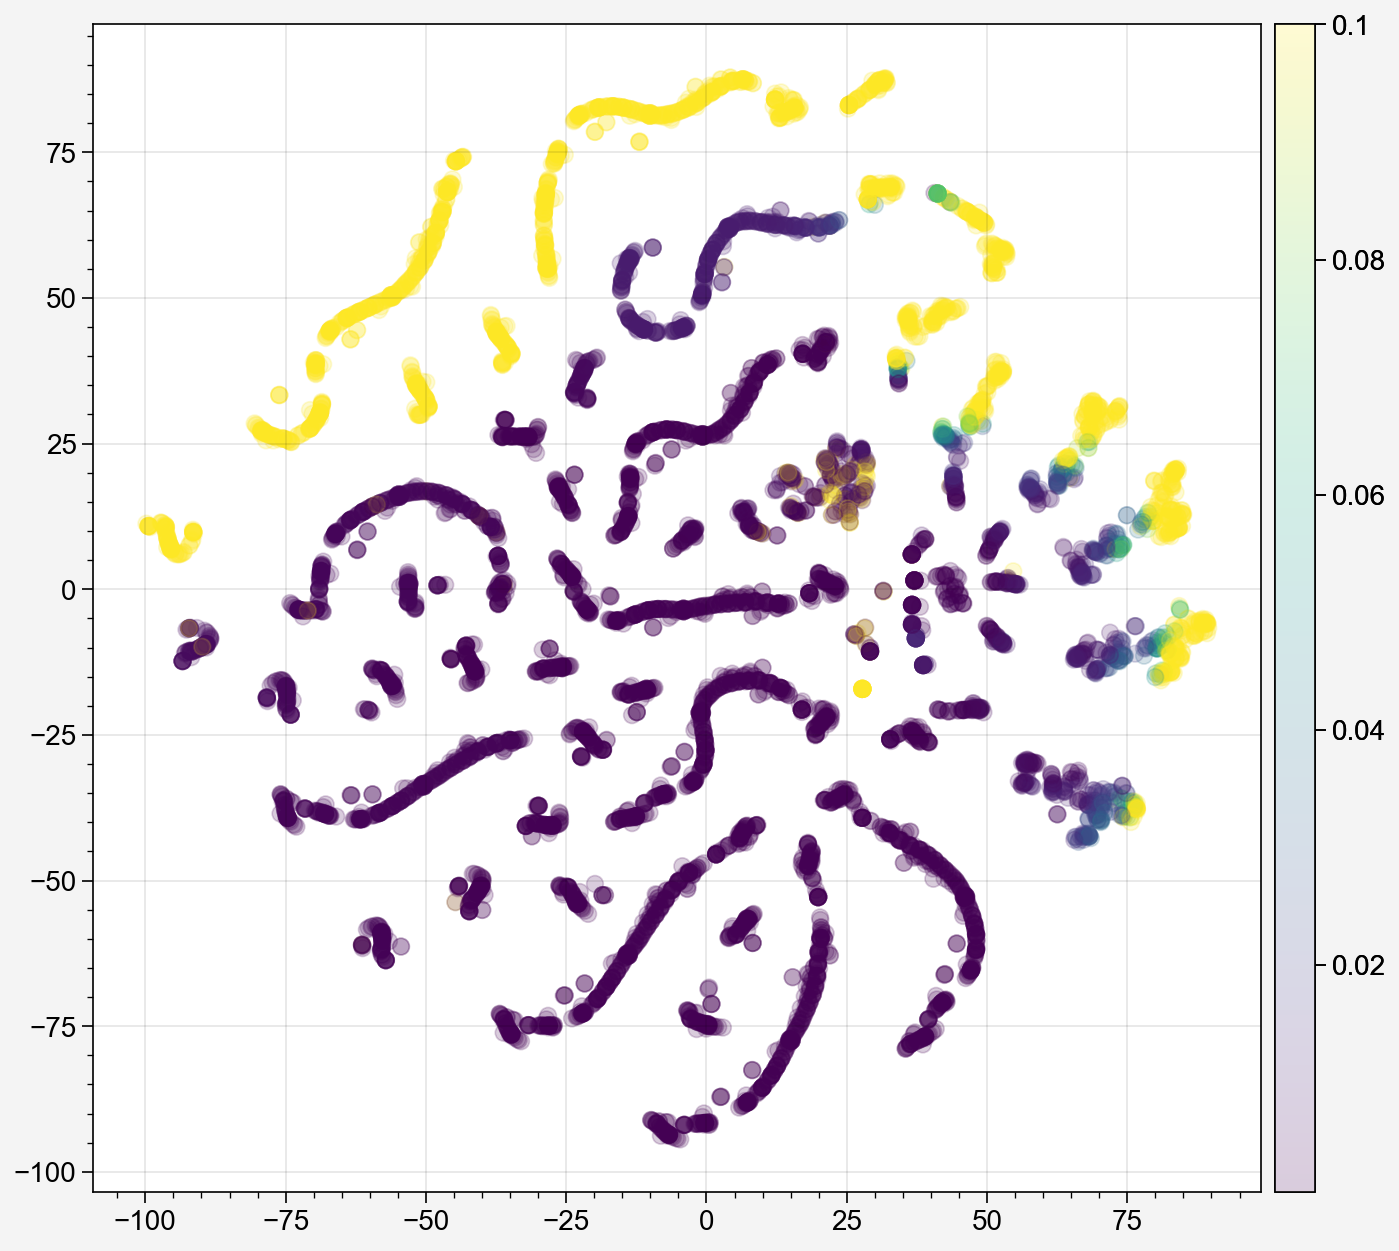

In [68]:

ap = np.vstack(res['action_probs'])[:, 1]
ap_clip = np.clip(ap, 0, 0.1)

fig, ax = pplt.subplots(figwidth=7)
cm = ax.scatter(rnn_hxs_2d[:, 0], rnn_hxs_2d[:, 1], c=ap_clip, alpha=0.2, cmap='Viridis')
ax.colorbar(cm)

<a list of 1 Line2D objects>

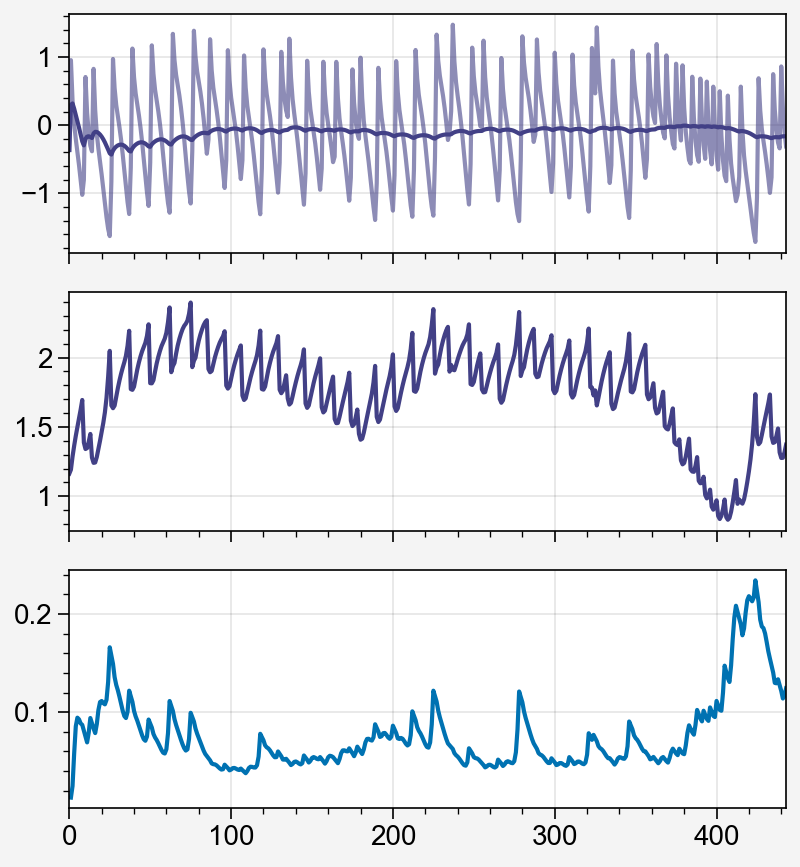

In [763]:

fig, ax = pplt.subplots(nrows=3, refaspect=3, figwidth=4, sharey=False)

balloon_sizes = np.arange(0.2, 1.01, 0.05)
pcas = comb_pca(res)
ep = 7
popped = np.array(res['data']['popped'][ep])
sizes = np.array(res['data']['last_size'][ep])
s = np.mean(sizes[~popped])
c = get_color_from_colormap(s, 0.2, 0.8, to_hex=False)
p = 1
ax[0].plot(pcas[ep][:, p], c=c, alpha=0.6)
ax[0].plot(pd.Series(pcas[ep][:, p]).ewm(alpha=0.01).mean(),
            c=c)
ax[1].plot(res['values'][ep].reshape(-1), c=c)

aps = res['action_probs'][ep][:, 1]
non_presses = aps < .5
steps = np.arange(len(aps))
npsteps = steps[non_presses]
npap = aps[non_presses]
npap = pd.Series(npap).ewm(alpha=0.1).mean()

ax[2].plot(npsteps, npap)

In [192]:
"""
Main section to collect a bunch of data on confidence
and activations
"""


import warnings
warnings.filterwarnings("ignore")

postfixes = ['', 'pop0.05', 'pop0.1']
models = [1.0, 1.2, 1.5, 1.7, 2.0]
trials = range(3)
chks = np.arange(10, 243, 30)

iterators = [postfixes, models, trials, chks]
iterators_idxs = [range(len(i)) for i in iterators]
sizes = [len(i) for i in iterators]

dec_flow_scores = np.zeros(sizes + [2]) # last axis: 0=decision nodes, 1=non-dec nodes
all_decision_nodes = np.zeros(sizes + [17, 64])

for i, j, k, l in tqdm(itertools.product(*iterators_idxs), total=np.prod(sizes)):
    postfix = postfixes[i]
    model = models[j]
    t = k
    chk = chks[l]
    
    exp_name = f"p{model}n50{postfix}"
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
    res = evalu(model, obs_rms)
    res = reshape_parallel_evalu_res(res, meta_balloons=40)
    
    score, dec_nodes = score_decision_flow(res, model)
    dec_flow_scores[i, j, k, l] = score.mean(axis=0)
    all_decision_nodes[i, j, k, l] = dec_nodes
        
pickle.dump({
    'dec_flow_scores': dec_flow_scores,
    'all_decision_nodes': all_decision_nodes
}, open('data/meta_rnn_decision_flows', 'wb'))
    

100%|██████████| 360/360 [35:39<00:00,  5.94s/it]
